# Quantile-quantile (QQ) scaled climate projections

In [4]:
import glob
import calendar
import sys
import gc

import xarray as xr
from xclim import sdba
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import xesmf as xe
import dask.diagnostics
import cmdline_provenance as cmdprov
#from dask.distributed import Client, LocalCluster
import dask

from calc_adjustment import read_data
from apply_adjustment import check_units

In [5]:
dask.diagnostics.ProgressBar().register()

In [48]:
# Parameters

cmip_var = 'tasmax'
obs_var = 'tmax'

cmip_units = 'K'
obs_units = 'C'
qq_units = 'C'

adjustment_file = '/g/data/wp00/users/dbi599/test_space/tasmax-qqscale-factors-additive_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_19950101-20141231_20350101-20641231.nc'
hist_files = [
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_19500101-19991231.nc',
    '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_historical_r1i1p1f1_gn_20000101-20141231.nc',
]
fut_files = [
    '/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20150101-20641231.nc',
    '/g/data/fs38/publications/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp370/r1i1p1f1/day/tasmax/gn/latest/tasmax_day_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_20650101-21001231.nc',    
]
obs_files = [
    '/g/data/xv83/agcd-csiro/tmax/daily/tmax_AGCD-CSIRO_r005_19100101-20220404_daily_space-chunked.zarr'
]
qq_file = '/g/data/wp00/users/dbi599/test_space/tasmax-qqscaled-additive_day_AGCD-ACCESS-ESM1-5_ssp370_r1i1p1f1_20350101-20641231.nc'



obs_name = 'AGCD'
model_name = 'ACCESS1-3'
future_scenario = 'rcp45'
model_run = 'r1i1p1'

obs_time_bounds = ['1995-01-01', '2014-12-31']
hist_time_bounds = ['1990-01-01', '2019-12-31']
fut_time_bounds = ['2035-01-01', '2064-12-31']

spatial_selection = [-44, -39.5, 143.5, 149]
spatial_aggregation = "none"

example_point = [-42.9, 147.3]
example_month = 6

output_units = 'C'
model_units = None

mapping_method = 'additive'

output_file = '/g/data/wp00/dbi599/tasmax_day_AGCD-ACCESS1-3_rcp45_r1i1p1_20210101-20401231.nc'

In [7]:
# Required parameters
#assert 'model_name' in locals(), "Must provide a model name"
#assert 'obs_name' in locals(), "Must provide the name of an observational dataset"
#assert 'variable' in locals(), "Must provide a variable name"

## Read data

In [49]:
ds_obs = read_data(
    obs_files,
    obs_var,
    time_bounds=obs_time_bounds,
    input_units=obs_units,
    output_units=qq_units
)

/g/data/wp00/users/dbi599/miniconda3/envs/cih/lib/python3.10/site-packages/xarray/backends/plugins.py:117: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/wp00/users/dbi599/miniconda3/envs/cih/lib/python3.10/site-packages/xarray/backends/plugins.py:117: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [50]:
ds_obs[obs_var]

<xarray.DataArray 'tmax' (time: 7305, lat: 691, lon: 886)>
dask.array<xarray-tmax, shape=(7305, 691, 886), dtype=float32, chunksize=(7305, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * time     (time) datetime64[ns] 1995-01-01T09:00:00 ... 2014-12-31T09:00:00
Attributes:
    analysis_time:              2018-08-16 23:45:40 UTC
    analysis_version_number:    2.01
    cell_methods:               time: maximum
    frequency:                  daily
    length_scale_for_analysis:  250.0
    long_name:                  Daily maximum air temperature
    source:                     Interpolated surface observations
    standard_name:              air_temperature
    units:                      °C

In [10]:
lat_min_obs = ds_obs['lat'].values.min()
lat_max_obs = ds_obs['lat'].values.max()
lon_min_obs = ds_obs['lon'].values.min()
lon_max_obs = ds_obs['lon'].values.max()

In [11]:
print(lat_min_obs, lat_max_obs, lon_min_obs, lon_max_obs)

-44.5 -10.0 112.0 156.25


In [12]:
ds_hist = read_data(
    hist_files,
    cmip_var,
    time_bounds=hist_time_bounds,
    input_units=cmip_units,
    output_units=qq_units)
ds_hist[cmip_var]

<xarray.DataArray 'tasmax' (time: 9131, lat: 145, lon: 192)>
dask.array<truediv, shape=(9131, 145, 192), dtype=float32, chunksize=(9131, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    units:          °C
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    history:        2019-11-15T17:36:46Z altered by CMOR: Treated scalar dime...

In [13]:
ds_future = read_data(
    fut_files,
    cmip_var,
    time_bounds=fut_time_bounds,
    input_units=cmip_units,
    output_units=qq_units)
ds_future[cmip_var]

<xarray.DataArray 'tasmax' (time: 10958, lat: 145, lon: 192)>
dask.array<truediv, shape=(10958, 145, 192), dtype=float32, chunksize=(10958, 145, 192), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2035-01-01T12:00:00 ... 2064-12-31T12:00:00
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    units:          °C
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    history:        2019-11-15T10:38:50Z altered by CMOR: Treated scalar dime...

In [14]:
ds_adjust = xr.open_dataset(adjustment_file)
qm = sdba.QuantileDeltaMapping.from_dataset(ds_adjust)

In [15]:
qm.ds

<xarray.Dataset>
Dimensions:    (lat: 145, lon: 192, month: 12, quantiles: 100)
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Data variables:
    af         (quantiles, month, lat, lon) float32 ...
    hist_q     (quantiles, month, lat, lon) float32 ...
Attributes:
    _xclim_adjustment:    {"py/object": "xclim.sdba.adjustment.EmpiricalQuant...
    adj_params:           EmpiricalQuantileMapping(group=Grouper(add_dims=[],...
    history:              Fri Aug 26 15:45:13 2022: /g/data/wp00/users/dbi599...
    base_period_start:    1995-01-01
    base_period_end:      2014-12-31
    future_period_start:  2035-01-01
    future_period_end:    2064-12-31

In [51]:
qq_obs = xr.open_dataset(qq_file)

## Quantile mapping

In [16]:
qm.ds['hist_q']

<xarray.DataArray 'hist_q' (quantiles: 100, month: 12, lat: 145, lon: 192)>
[33408000 values with dtype=float32]
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Attributes:
    standard_name:  Model quantiles
    long_name:      Quantiles of model on the reference period

In [17]:
def quantile_month_plot(da, cmap=None, diverging=False, point=None):
    """Create two dimensional month/quantile plot"""

    fig, ax = plt.subplots(figsize=[16, 6])
    if 'lat' in da.dims:
        example_lat, example_lon = example_point
        point_selection = {'lat': example_lat, 'lon': example_lon}
    else:
        point_selection = {}
    quantiles = da.sel(point_selection, method='nearest')
    if diverging:
        abs_max = np.max(np.abs(quantiles.values))
        vmax = abs_max
        vmin = -1 * abs_max
    else:
        vmin = vmax = None
    quantiles.transpose('month', 'quantiles').plot(cmap=cmap, vmax=vmax, vmin=vmin)
    yticks = np.arange(1,13)
    ytick_labels = [calendar.month_abbr[i] for i in yticks]
    plt.yticks(yticks, ytick_labels)
    ax.invert_yaxis()
    plt.show()

In [28]:
def quantile_spatial_plot(
    da, month, lat_bounds=None, lon_bounds=None, example_point=None, cmap=None, diverging=False,
):
    """Spatial plot of the 10th, 50th and 90th percentile"""
    
    da_selection = da.sel({'quantiles': [.1, .5, .9], 'month': month}, method='nearest')
    if lat_bounds:
        lat_min_obs, lat_max_obs = lat_bounds
        da_selection = da_selection.sel(lat=slice(lat_min_obs, lat_max_obs))
    if lon_bounds:
        lon_min_obs, lon_max_obs = lon_bounds
        da_selection = da_selection.sel(lon=slice(lon_min_obs, lon_max_obs))
    if diverging:
        abs_max = np.max(np.abs(da_selection.values))
        vmax = abs_max
        vmin = -1 * abs_max
    else:
        vmin = vmax = None
    p = da_selection.plot(
        col='quantiles',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        figsize=[20, 5.5],
        subplot_kws={'projection': ccrs.PlateCarree(),},
        vmax=vmax,
        vmin=vmin,
    )
    for ax in p.axes.flat:
        ax.coastlines()
        if example_point:
            lat, lon = example_point
            ax.plot(lon, lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    plt.suptitle(calendar.month_name[month])
    plt.show()

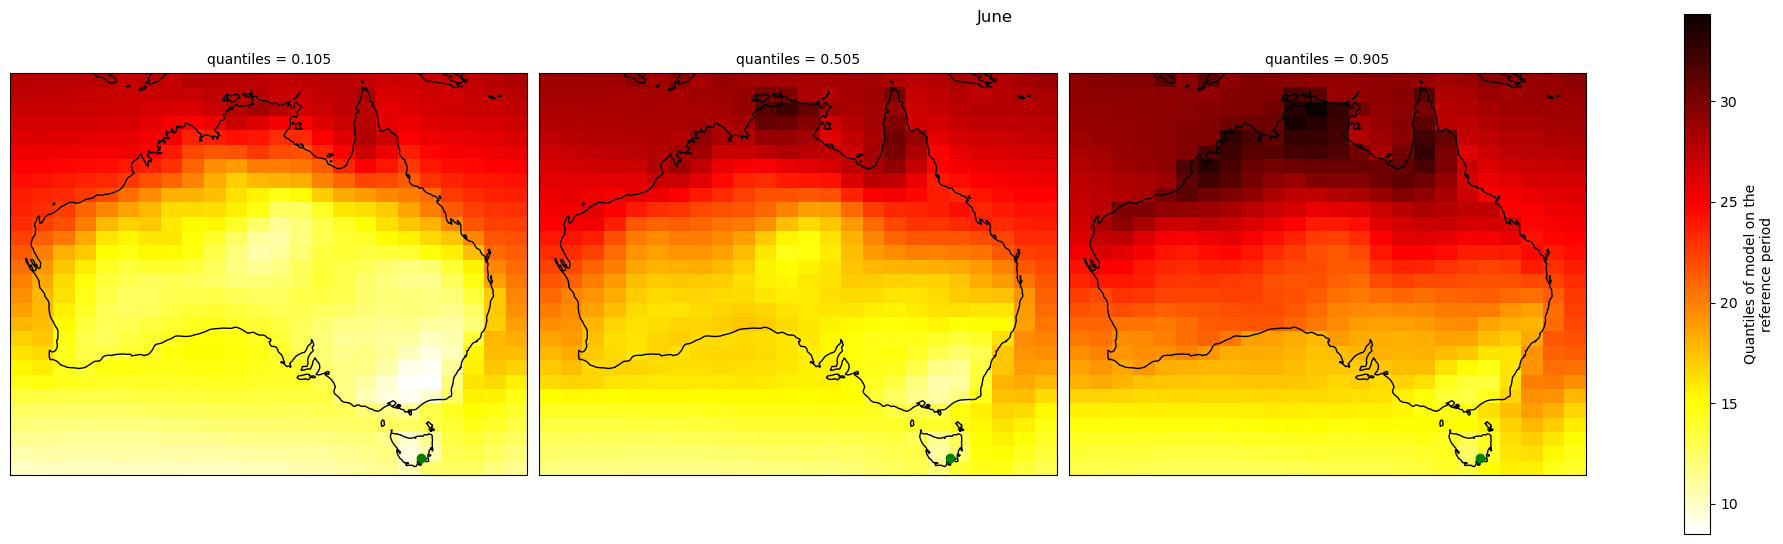

In [29]:
if 'lat' in qm.ds.dims:
    quantile_spatial_plot(
        qm.ds['hist_q'],
        example_month,
        lat_bounds=[lat_min_obs, lat_max_obs],
        lon_bounds=[lon_min_obs, lon_max_obs],
        example_point=example_point,
        cmap='hot_r',
    )

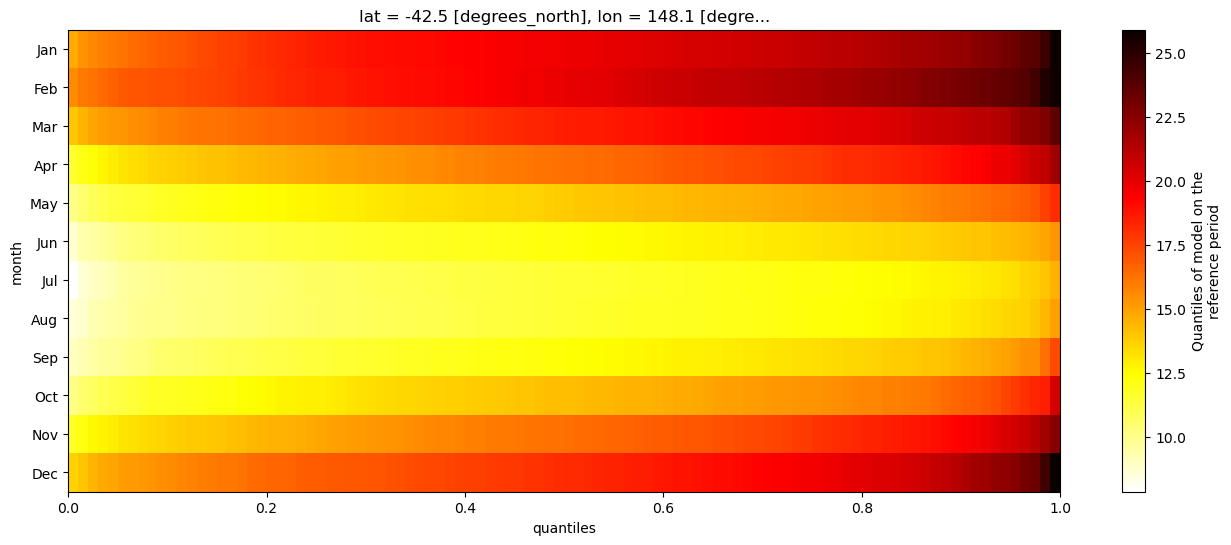

In [31]:
quantile_month_plot(qm.ds['hist_q'], cmap='hot_r', point=example_point)

In [32]:
qm.ds['af']

<xarray.DataArray 'af' (quantiles: 100, month: 12, lat: 145, lon: 192)>
[33408000 values with dtype=float32]
Coordinates:
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Attributes:
    standard_name:  Adjustment factors
    long_name:      Quantile mapping adjustment factors

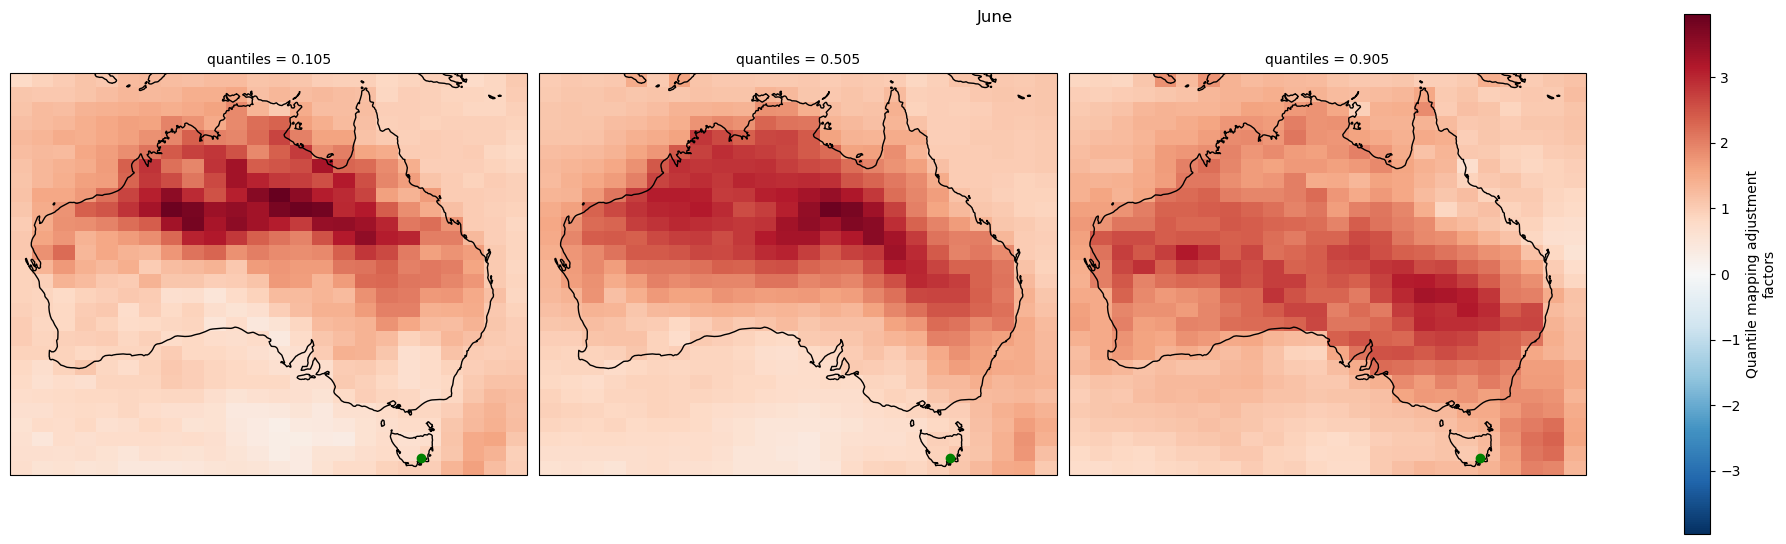

In [33]:
if 'lat' in qm.ds.dims:
    quantile_spatial_plot(
        qm.ds['af'],
        example_month,
        lat_bounds=[lat_min_obs, lat_max_obs],
        lon_bounds=[lon_min_obs, lon_max_obs],
        example_point=example_point,
        cmap='RdBu_r',
        diverging=True,
    )

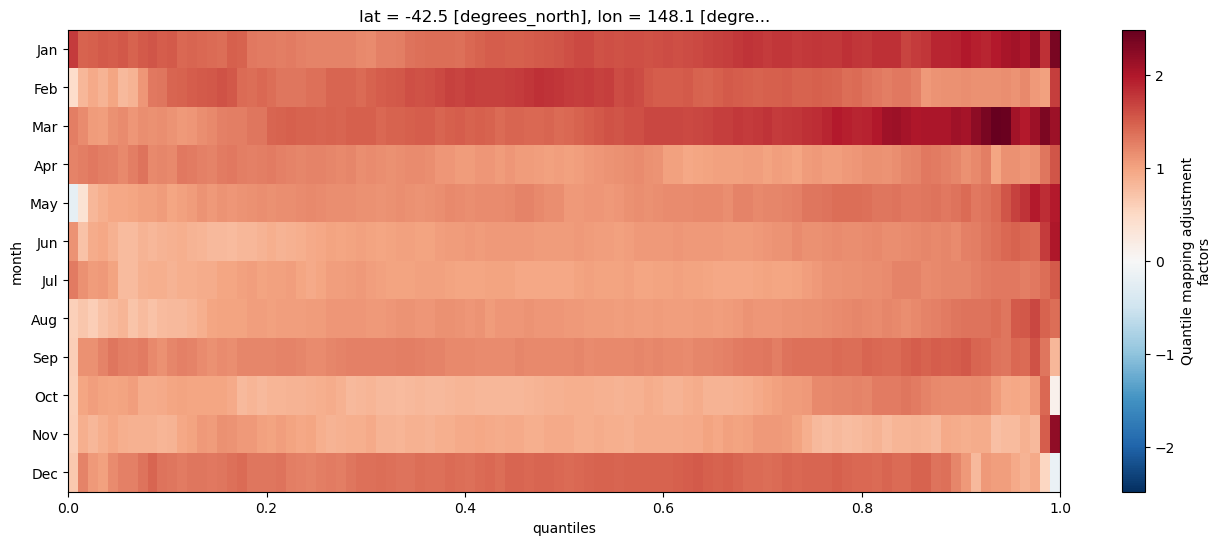

In [34]:
quantile_month_plot(qm.ds['af'], cmap='RdBu_r', point=example_point, diverging=True)

## QQ-scaled projections

In [57]:
model_sel = {'lat': slice(lat_min_obs, lat_max_obs), 'lon': slice(lon_min_obs, lon_max_obs)}
hist_clim = ds_hist[cmip_var].sel(model_sel).mean('time', keep_attrs=True)
future_clim = ds_future[cmip_var].sel(model_sel).mean('time', keep_attrs=True)
model_mean_change = future_clim - hist_clim

In [60]:
obs_clim = ds_obs[obs_var].mean('time', keep_attrs=True)

In [68]:
qq_clim = qq_obs[obs_var].mean('time', keep_attrs=True)

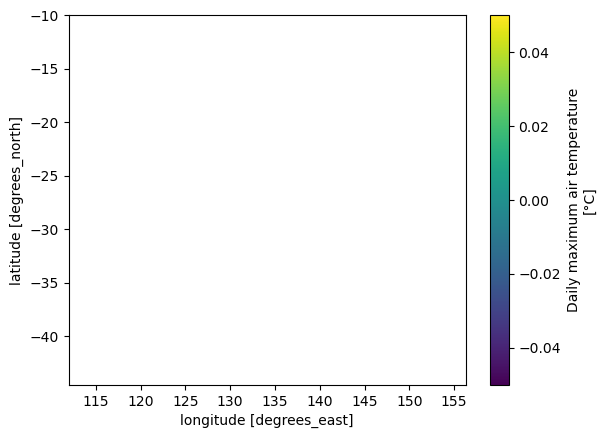

In [69]:
qq_clim.plot()

In [ ]:
qq_mean_change = qq_clim - obs_clim

In [71]:
## TODO: Put the qq_mean_change and model_mean_change on the same grid and look at the difference.

In [42]:
model_abs_max = np.max(np.abs(model_change.values))
qq_abs_max = np.max(np.abs(qq_change.values))
abs_max = np.max([model_abs_max, qq_abs_max])
vmax = abs_max
vmin = -1 * abs_max

fig = plt.figure(figsize=[16, 6])

ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
model_mean_change.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmax=vmax,
    vmin=vmin
)
ax1.set_title('Original')

ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree())
qq_mean_change.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmax=vmax,
    vmin=vmin
)
ax2.set_title('QQ-scaled')

for ax in [ax1, ax2]:
    ax.coastlines()
    if example_point:
        lat, lon = example_point
        ax.plot(lon, lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())

plt.suptitle(f'{model_name}, {future_scenario} projected change')
plt.show()

[########################################] | 100% Completed | 8.35 ss
[########################################] | 100% Completed | 8.45 s
[########################################] | 100% Completed | 9.67 ss
[########################################] | 100% Completed | 9.77 s
[########################################] | 100% Completed | 926.92 ms
[########################################] | 100% Completed | 928.73 ms


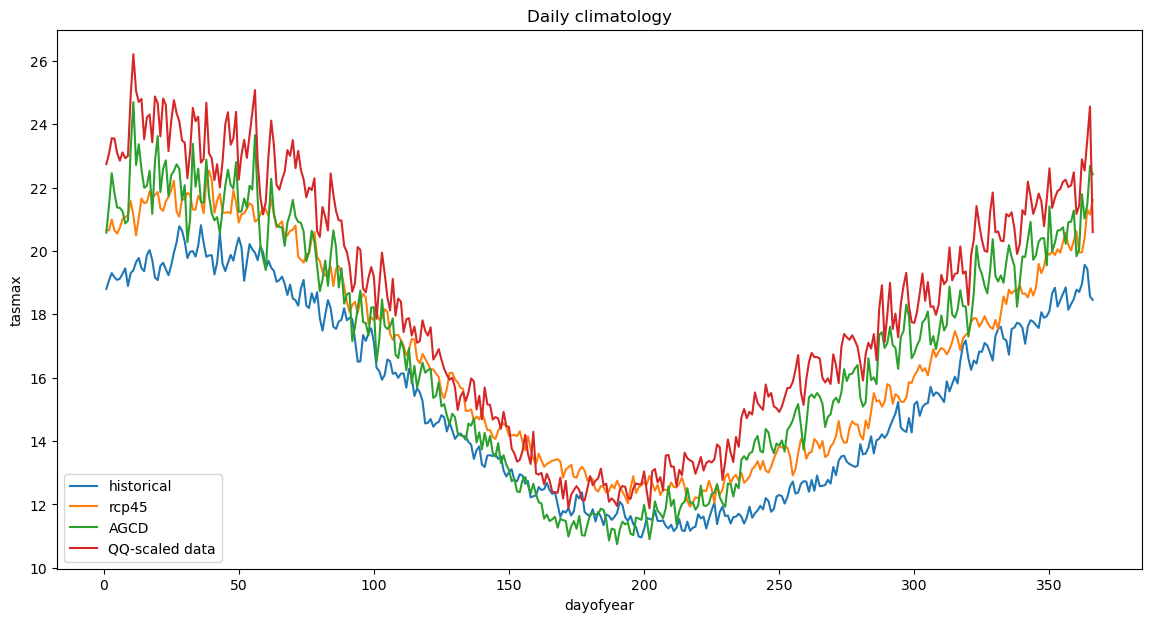

In [44]:
fig, ax = plt.subplots(figsize=[14, 7])
if 'lat' in qq_obs.dims:
    example_lat, example_lon = example_point
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
ds_hist[cmip_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="historical")
ds_future[cmip_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label=future_scenario)
ds_obs[obs_var].sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label=obs_name)
qq_obs.sel(point_selection, method='nearest').groupby("time.dayofyear").mean().plot(label="QQ-scaled data")
plt.legend()
plt.title('Daily climatology')
plt.show()

[########################################] | 100% Completed | 104.10 ms
[########################################] | 100% Completed | 202.37 ms


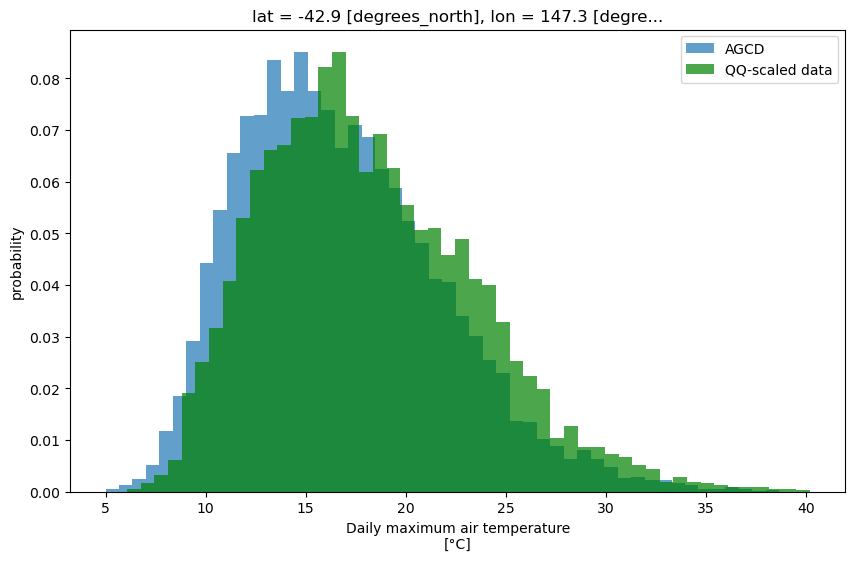

In [45]:
fig = plt.figure(figsize=[10, 6])
if 'lat' in qq_obs.dims:
    example_lat, example_lon = example_point
    point_selection = {'lat': example_lat, 'lon': example_lon}
else:
    point_selection = {}
ds_obs[obs_var].sel(point_selection, method='nearest').plot.hist(bins=50, density=True, label=obs_name, alpha=0.7)
qq_obs.sel(point_selection, method='nearest').plot.hist(bins=50, density=True, label='QQ-scaled data', facecolor='green', alpha=0.7)
plt.ylabel('probability')
plt.legend()
plt.show()